In [156]:
import numpy as np
from itertools import product
import pickle

np.random.seed(41)

thetas1 = np.array([1, 1, 1])
thetas2 = np.array([5.5, 7.5, 10.5])
time_steps = 50
choices = 3

# Set theta parameters
min_vals = [1, 1, 1]           # minimum values
max_vals = [10, 10, 10]         # maximum values  
resolutions = [1, 1, 1] # different resolution for each variable

# Generate all combinations
theta_hat = np.array(list(product(
    np.arange(min_vals[0], max_vals[0] + resolutions[0], resolutions[0]),
    np.arange(min_vals[1], max_vals[1] + resolutions[1], resolutions[1]), 
    np.arange(min_vals[2], max_vals[2] + resolutions[2], resolutions[2])
)))
print(f"theta_hat: \n{theta_hat}")

# Initialize lists to store data over time
ego_robust_prediction_outcomes = []
ego_sec_policy_outcomes = []
theta_hat_history = []
sigma_history = []
sigma_worst_history = []

gamma_history = []

for t in range(time_steps):
    print()
    print(f'Round {t}')
    
    # get costs
    A1 = np.round(np.random.uniform(0,1, size=(choices, choices)), 2)
    B1 = np.round(np.random.uniform(0,1, size=(choices, choices)), 2)
    C1 = np.round(np.random.uniform(0,1, size=(choices, choices)), 2)
    A2 = -A1
    B2 = B1
    C2 = C1
    
    # find composite matrices
    D1 = np.tensordot(thetas1, np.stack([A1, B1, C1]), axes=1)
    D2 = np.tensordot(thetas2, np.stack([A2, B2, C2]), axes=1)
    
    print()
    print(f"D1: \n{D1}")
    print()
    print(f"D2: \n{D2}")
    
    # predict all possible opponent security policies
    D2_hat = []
    sigma_hat = []
    for theta_combination in theta_hat:
        D2_instance = np.tensordot(theta_combination, np.stack([A2, B2, C2]), axes=1)
        D2_hat.append(D2_instance)
        sigma_instance = np.argmin(np.max(D2_instance, axis=0))
        sigma_hat.append(sigma_instance)
    
    print()
    print(f"sigma_hat: \n{sigma_hat}")
    
    # find the worst possible opponent policy, design best response
    worst_outcome = -1000
    gamma = None
    sigma_worst = None
    for sigma_possible in set(sigma_hat):
        outcome = np.min(D1[:,sigma_possible])
        if outcome > worst_outcome:
            worst_outcome = outcome
            sigma_worst = sigma_possible
            gamma = np.argmin(D1[:, sigma_possible])
    
    # observe actual policy
    sigma = np.argmin(np.max(D2, axis=0))
    ego_game_outcome = D1[gamma][sigma]
    
    gamma_s = np.argmin(np.max(D1, axis=1))
    ego_sec_outcome = D1[gamma_s][sigma]

    print()
    print(f'(gamma, sigma): {(gamma, sigma)}')
    print(f"sigma_worst: {sigma_worst}")
    print(f"gamma_s: {gamma_s}")
    print(f"ego_game_outcome: {ego_game_outcome}")
    
    # Store data
    ego_robust_prediction_outcomes.append(ego_game_outcome)
    ego_sec_policy_outcomes.append(ego_sec_outcome)
    theta_hat_history.append(theta_hat.copy())
    sigma_worst_history.append(sigma_worst)
    sigma_history.append(sigma)
    gamma_history.append(gamma)
    
    # update possible theta space matching
    matching_sigma_indices = np.argwhere(np.array(sigma_hat) == sigma)
    theta_hat = theta_hat[matching_sigma_indices.ravel()]
    
    print()
    print(f"theta_hat after: \n{theta_hat}")

# Save the data
simulation_data = {
    'ego_outcomes': ego_robust_prediction_outcomes,    
    'ego_sec_policy_outcomes': ego_sec_policy_outcomes,
    'theta_hat_history': theta_hat_history,
    'sigma_worst_history': sigma_worst_history,
    'sigma_history': sigma_history,
    'gamma_history': gamma_history,
    'time_steps': time_steps
}

# Save to pickle file
with open('game_theory_simulation_data.pkl', 'wb') as f:
    pickle.dump(simulation_data, f)

print("\nData saved to 'game_theory_simulation_data.pkl'")
print(f"Final ego outcomes: {ego_robust_prediction_outcomes}")
print(f"Final theta_hat size progression: {[len(th) for th in theta_hat_history]}")

theta_hat: 
[[ 1  1  1]
 [ 1  1  2]
 [ 1  1  3]
 ...
 [10 10  8]
 [10 10  9]
 [10 10 10]]

Round 0

D1: 
[[1.42 0.78 1.57]
 [0.96 0.86 1.47]
 [0.49 1.81 1.6 ]]

D2: 
[[9.65  6.4   4.765]
 [8.87  6.15  4.395]
 [1.895 6.185 1.15 ]]

sigma_hat: 
[2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

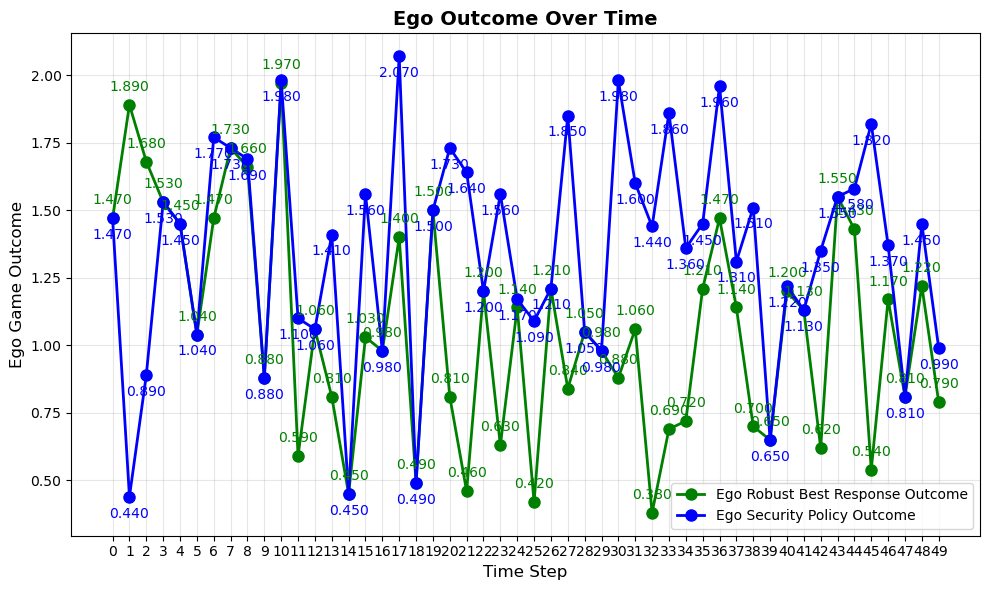

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

ego_outcomes = data['ego_outcomes']
ego_sec_policy_outcomes = data['ego_sec_policy_outcomes']
time_steps = data['time_steps']

# Plot 1: Ego Outcome Over Time
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), ego_outcomes, 'g-o', linewidth=2, markersize=8, label='Ego Robust Best Response Outcome')
plt.plot(range(time_steps), ego_sec_policy_outcomes, 'b-o', linewidth=2, markersize=8, label='Ego Security Policy Outcome')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Ego Game Outcome', fontsize=12)
plt.title('Ego Outcome Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(time_steps))
plt.legend()

# Add value labels on points for ego_outcomes
for i, outcome in enumerate(ego_outcomes):
    plt.annotate(f'{outcome:.3f}', (i, outcome), 
                textcoords="offset points", xytext=(0,10), ha='center', color='green')

# Add value labels on points for ego_sec_policy_outcomes
for i, outcome in enumerate(ego_sec_policy_outcomes):
    plt.annotate(f'{outcome:.3f}', (i, outcome), 
                textcoords="offset points", xytext=(0,-15), ha='center', color='blue')

plt.tight_layout()
plt.show()


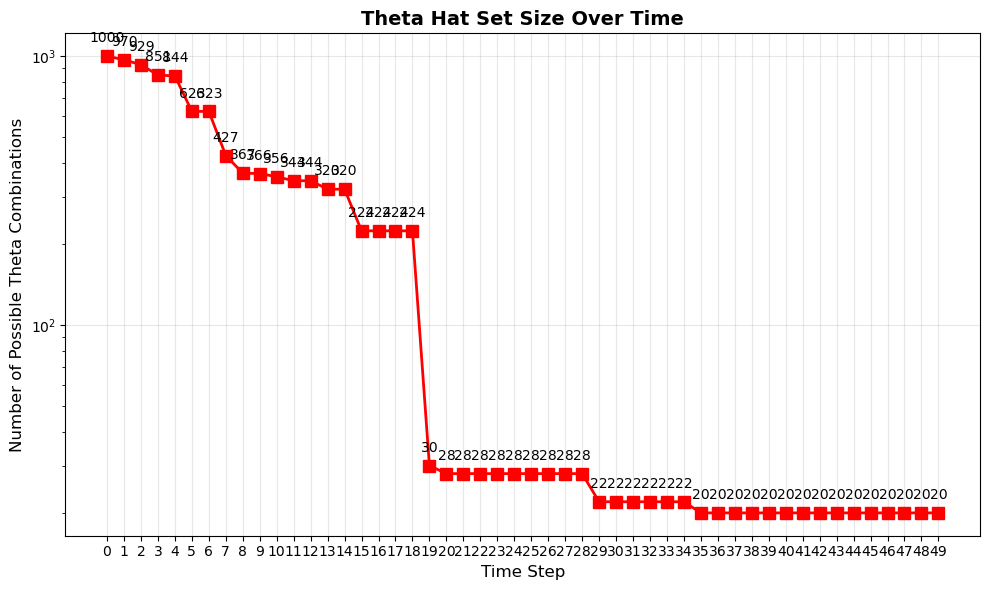

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

theta_hat_history = data['theta_hat_history']
time_steps = data['time_steps']

# Plot 2: Theta Hat Set Size Over Time
theta_hat_sizes = [len(theta_set) for theta_set in theta_hat_history]

plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), theta_hat_sizes, 'r-s', linewidth=2, markersize=8)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Number of Possible Theta Combinations', fontsize=12)
plt.title('Theta Hat Set Size Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(time_steps))
plt.yscale('log')  # Log scale since it decreases exponentially

# Add value labels on points
for i, size in enumerate(theta_hat_sizes):
    plt.annotate(f'{size}', (i, size), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from itertools import product

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

theta_hat_history = data['theta_hat_history']
time_steps = data['time_steps']

# Plot 3: Theta Hat Evolution Heatmap
plt.figure(figsize=(14, 8))

# Generate all possible combinations
all_possible_thetas = np.array(list(product(
    np.arange(min_vals[0], max_vals[0] + resolutions[0], resolutions[0]),
    np.arange(min_vals[1], max_vals[1] + resolutions[1], resolutions[1]),
    np.arange(min_vals[2], max_vals[2] + resolutions[2], resolutions[2])
)))
theta_strings = [f"({int(theta[0])},{int(theta[1])},{int(theta[2])})" for theta in all_possible_thetas]

# Create matrix to track which thetas are possible at each time step
theta_matrix = np.zeros((len(all_possible_thetas), time_steps))

for t in range(time_steps):
    current_theta_hat = theta_hat_history[t]
    for i, possible_theta in enumerate(all_possible_thetas):
        # Check if this theta is in the current theta_hat
        for theta in current_theta_hat:
            if np.array_equal(possible_theta, theta):
                theta_matrix[i, t] = 1
                break

# Create the heatmap
im = plt.imshow(theta_matrix, cmap='RdYlBu', aspect='auto')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Theta Combinations', fontsize=12)
plt.title('Theta Hat Set Evolution Over Time', 
          fontsize=14, fontweight='bold')
plt.xticks(range(time_steps))

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Theta Possibility', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 50)
print("SIMULATION SUMMARY")
print("=" * 50)
print(f"Initial theta_hat size: {len(theta_hat_history[0])}")
print(f"Final theta_hat size: {len(theta_hat_history[-1])}")
print(f"Final remaining theta combinations:")
for theta in theta_hat_history[-1]:
    print(f"  {theta}")

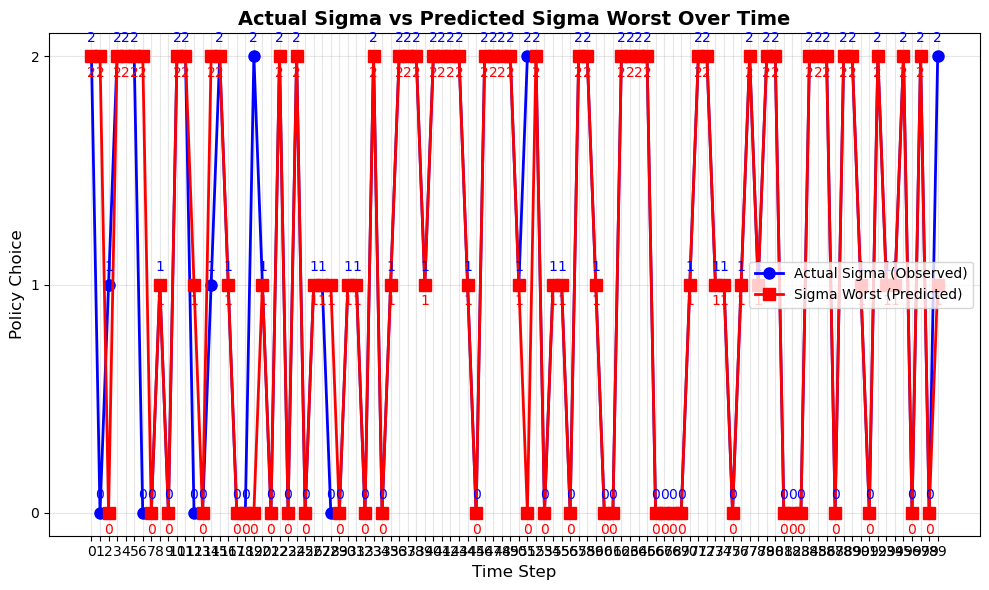

SIGMA PREDICTION ANALYSIS
Prediction accuracy: 91/100 = 91.0%
Average difference: 0.13
Max difference: 2

Time step breakdown:
t0: σ=2, σ_worst=2 ✓
t1: σ=0, σ_worst=2 ✗
t2: σ=1, σ_worst=0 ✗
t3: σ=2, σ_worst=2 ✓
t4: σ=2, σ_worst=2 ✓
t5: σ=2, σ_worst=2 ✓
t6: σ=0, σ_worst=2 ✗
t7: σ=0, σ_worst=0 ✓
t8: σ=1, σ_worst=1 ✓
t9: σ=0, σ_worst=0 ✓
t10: σ=2, σ_worst=2 ✓
t11: σ=2, σ_worst=2 ✓
t12: σ=0, σ_worst=1 ✗
t13: σ=0, σ_worst=0 ✓
t14: σ=1, σ_worst=2 ✗
t15: σ=2, σ_worst=2 ✓
t16: σ=1, σ_worst=1 ✓
t17: σ=0, σ_worst=0 ✓
t18: σ=0, σ_worst=0 ✓
t19: σ=2, σ_worst=0 ✗
t20: σ=1, σ_worst=1 ✓
t21: σ=0, σ_worst=0 ✓
t22: σ=2, σ_worst=2 ✓
t23: σ=0, σ_worst=0 ✓
t24: σ=2, σ_worst=2 ✓
t25: σ=0, σ_worst=0 ✓
t26: σ=1, σ_worst=1 ✓
t27: σ=1, σ_worst=1 ✓
t28: σ=0, σ_worst=1 ✗
t29: σ=0, σ_worst=0 ✓
t30: σ=1, σ_worst=1 ✓
t31: σ=1, σ_worst=1 ✓
t32: σ=0, σ_worst=0 ✓
t33: σ=2, σ_worst=2 ✓
t34: σ=0, σ_worst=0 ✓
t35: σ=1, σ_worst=1 ✓
t36: σ=2, σ_worst=2 ✓
t37: σ=2, σ_worst=2 ✓
t38: σ=2, σ_worst=2 ✓
t39: σ=1, σ_worst=1 ✓
t40

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_history = data['sigma_history']
sigma_worst_history = data['sigma_worst_history']
time_steps = data['time_steps']

# Plot 4: Sigma vs Sigma Worst Over Time
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), sigma_history, 'b-o', linewidth=2, markersize=8, label='Actual Sigma (Observed)')
plt.plot(range(time_steps), sigma_worst_history, 'r-s', linewidth=2, markersize=8, label='Sigma Worst (Predicted)')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Policy Choice', fontsize=12)
plt.title('Actual Sigma vs Predicted Sigma Worst Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(time_steps))
plt.yticks(range(max(max(sigma_history), max(sigma_worst_history)) + 1))
plt.legend()

# Add value labels on points
for i, (sigma, sigma_worst) in enumerate(zip(sigma_history, sigma_worst_history)):
    plt.annotate(f'{sigma}', (i, sigma), 
                textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f'{sigma_worst}', (i, sigma_worst), 
                textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()

# Calculate and print accuracy statistics
matches = sum(1 for s, sw in zip(sigma_history, sigma_worst_history) if s == sw)
accuracy = matches / len(sigma_history) * 100

print("=" * 50)
print("SIGMA PREDICTION ANALYSIS")
print("=" * 50)
print(f"Prediction accuracy: {matches}/{len(sigma_history)} = {accuracy:.1f}%")
print(f"Average difference: {np.mean([abs(s - sw) for s, sw in zip(sigma_history, sigma_worst_history)]):.2f}")
print(f"Max difference: {max([abs(s - sw) for s, sw in zip(sigma_history, sigma_worst_history)])}")

print("\nTime step breakdown:")
for i, (sigma, sigma_worst) in enumerate(zip(sigma_history, sigma_worst_history)):
    match_str = "✓" if sigma == sigma_worst else "✗"
    print(f"t{i}: σ={sigma}, σ_worst={sigma_worst} {match_str}")